In [1]:
from pynq import Overlay
from pynq.lib.iic import *
#from ov5640_config import *
from pynq.lib.video import *
from matplotlib import pyplot as plt
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
#import dma
import os
import shutil
from PIL import Image
import IPython
import cv2
from train import CNN
import time

from pynq.overlays.base import BaseOverlay
from pynq.lib.video import *
base = BaseOverlay("base.bit")


In [2]:

frame_in_w = 640
frame_in_h = 480

In [3]:

classes = ['mask_weared_incorrect','with_mask','without_mask']
model_path = r'mask.pth'
model = CNN()
model.load_state_dict(torch.load(model_path, map_location=lambda storage, loc: storage))
transform = transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(128),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])                                             


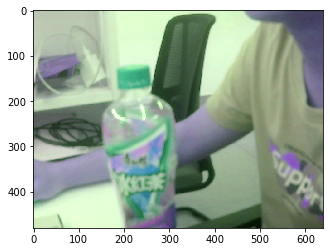

Epoch 1 Empty window!


RuntimeError: Failed to read from camera.

In [13]:

for i in range(5):


    videoin=cv2.VideoCapture(0)
    videoin.set(cv2.CAP_PROP_FRAME_WIDTH,frame_in_w);
    videoin.set(cv2.CAP_PROP_FRAME_HEIGHT,frame_in_h);
    ret, frame = videoin.read()

    if (ret):
        img = Image.fromarray(frame)
        g, b, r = img.split()
        img = Image.merge('RGB', [b,g,r])

        np_frame = np.asarray(img)
        face_cascade = cv2.CascadeClassifier(
            '/home/xilinx/jupyter_notebooks/base/video/data/'
            'haarcascade_frontalface_default.xml'
        )
        gray = cv2.cvtColor(np_frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.15, 3, 0)
        

        plt.imshow(img)
        plt.show()
        

        if len(faces)==0:
            print("Epoch {} Empty window!".format(i+1))
            videoIn.release()

        elif len(faces)==1:

            for (x,y,w,h) in faces:
                item = np_frame[y:y+h, x:x+w]
                cv2.imwrite("temp1.png", item)
                image = Image.open("temp1.png")
                image = image.convert('RGB')
                image_torch = transform(image)
                image_torch = image_torch.view(-1, 3, 128, 128)
            

                output = model(image_torch)
                _, predicted = torch.max(output.data, dim=1)
                pred = predicted[0].numpy()

                if pred==0:
                    print("Epoch {} Result: mask_weared_incorrect".format(i+1))
                    videoIn.release()
                elif pred==1:
                    print("Epoch {} Result: with_mask".format(i+1))
                    videoIn.release()
                elif pred==2:
                    print("Epoch {} Result: without_mask".format(i+1))
                    videoIn.release()
        else:

            flag = 0

            temp = faces
            for (x, y, w, h) in temp:

                j = 0
                for(x1, y1, w1, h1) in faces:
                    cond1 = ((x1>x)and(x1<(x+w)))or(((x1+w1)>x)and((x1+w1)<(x+w)))#检测当前人脸水平边框是否包含在外层循环项中
                    cond2 = ((y1>y)and(y1<(y+h)))or(((y1+h1)>y)and((y1+h1)<(y+h)))#检测当前人脸竖直边框是否包含在外层循环项中
                    cond3 = (w1*h1)<(w*h)#检测当前人脸面积是否小于外层循环项人脸（避免留下小人脸，删去大人脸）
                    if cond1 and cond2 and cond3:
                        faces=np.delete(faces,[j],axis=0)#满足以上三个条件时，删去该项
                    j = j+1
        
            for (x,y,w,h) in faces:
                item = np_frame[y:y+h, x:x+w]
                cv2.imwrite("temp1.png", item)
                image = Image.open("temp1.png")
                image = image.convert('RGB')
                image_torch = transform(image)
                image_torch = image_torch.view(-1, 3, 128, 128)
            #对单张人脸的前置处理
            #传入模型进行预测
                output = model(image_torch)
                _, predicted = torch.max(output.data, dim=1)
                pred = predicted[0].numpy()
                if pred==0:
                    if flag==0:
                    #标志为0说明为本行第一次输出
                        print("Epoch {} Result: mask_weared_incorrect".format(i+1),end = ' ')
                        flag = 1
                    else:
                    #标志为1说明本行前方已有输出
                        print(" mask_weared_incorrect",end = ' ')
                    #此处不换行
                elif pred==1:
                    if flag==0:
                        print("Epoch {} Result: with_mask".format(i+1),end = ' ')
                        flag = 1
                    else:
                        print(" with_mask",end = ' ')
                elif pred==2:
                    if flag==0:
                        print("Epoch {} Result: without_mask".format(i+1),end = ' ')
                        flag = 1
                    else:
                        print(" without_mask",end = ' ')
            print(" ")
        time.sleep(2)
    
    else:
        raise RuntimeError("Failed to read from camera.")
    

# 注意⚠

In [ ]:
#注意debug时要先运行这段代码将摄像头释放，否则内核容易崩溃
videoIn.release()